In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [7]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.distance_measures import nearestNeighborsOnAttribute
import pandas as pd
import torch
import copy 

In [4]:
attributes = ['Song_Name','Artist_Name','Album_Name','Genre','Price','CopyRight','Time','Released']

## Hybrid

### Datasets creation

In [9]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/itunes_amazon_hybrid.pth')
hybrid_model = hybrid_model.to('cuda')

In [11]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,
                             '../../datasets/Structured/itunes-amazon/','test_negatives')


Reading and processing data from "../../datasets/Structured/itunes-amazon/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [7]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,'../../datasets/Structured/itunes-amazon','negatives')

In [8]:
positives = returnLayerInputUnlabeled(hybrid_model_c,hybrid_model_c.classifier,
                               '../../datasets/Structured/itunes-amazon','positives')

In [12]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Structured/itunes-amazon/','test_positives')


Reading and processing data from "../../datasets/Structured/itunes-amazon/test_positives.csv"
0% [########################### ] 100% | ETA: 00:00:00

### Negative sample analysis

In [14]:
negatives_ri,neg_rinorms_df= computeRi(hybrid_model.classifier,
                                                    attributes,testneg,0)

100%|██████████| 82/82 [00:23<00:00,  3.52it/s]


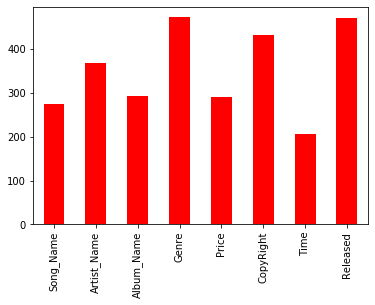

In [16]:
neg_rinorms_df.sum().plot.bar(color='red')

In [14]:
torch.save(negatives_ri,'experiments/results/testneg_ri_hybrid.pt')
neg_rinorms_df.to_csv('experiments/results/testneg_ri_norms.csv',index=False)

## Positive samples analisys

In [17]:
pos_ri_hybrid,pos_rinorms_df = computeRi(hybrid_model.classifier,attributes,
                                              testpos,1)

100%|██████████| 27/27 [00:09<00:00,  2.91it/s]


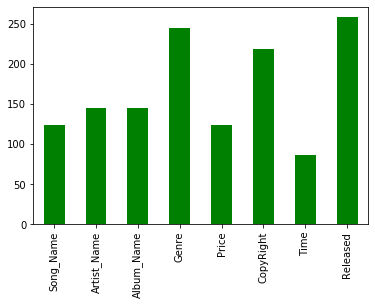

In [18]:
pos_rinorms_df.sum().plot.bar(color='green')

In [13]:
torch.save(pos_ri_hybrid,'experiments/results/testpos_ri_hybrid.csv')
pos_rinorms_df.to_csv('experiments/results/testpos_ri_norms.csv',index=False)

## Nearest neighbors hybrid

In [15]:
pos_ri = torch.load('experiments/results/testpos_ri_hybrid.pt')
neg_ri = torch.load('experiments/results/testneg_ri_hybrid.pt')

In [19]:
attribute_len = int(len(list(testpos.values())[0])/len(attributes))

In [21]:
positives_nn_hybrid = nearestNeighborsOnAttribute(testpos,pos_ri,
                                                       negatives,attributes,attribute_len,
                                                               min_similarity=0)

100%|██████████| 27/27 [00:00<00:00, 232.28it/s]


In [23]:
negatives_nn_hybrid = nearestNeighborsOnAttribute(testneg,neg_ri,
                                                        positives,attributes,attribute_len,
                                                               min_similarity=0)

100%|██████████| 82/82 [00:00<00:00, 277.98it/s]


In [24]:
positives_nn_hybrid.to_csv('experiments/results/testposNN_hybrid.csv',index=False)
negatives_nn_hybrid.to_csv('experiments/results/testnegNN_hybrid.csv',index=False)

In [25]:
positives_nn_hybrid['Price'].value_counts()

71     19
503     7
178     1
Name: Price, dtype: int64

In [30]:
negatives_nn_hybrid['Time'].value_counts()

659    13
665    13
101     9
95      6
9       5
638     5
235     5
98      5
676     3
90      3
460     2
684     2
237     2
273     2
521     2
131     1
102     1
722     1
499     1
274     1
Name: Time, dtype: int64

In [27]:
negatives = pd.read_csv('../../datasets/Structured/itunes-amazon/negatives.csv')
positives = pd.read_csv('../../datasets/Structured/itunes-amazon/positives.csv')

In [35]:
positives[positives.id==9]

,label,ltable_Song_Name,ltable_Artist_Name,ltable_Album_Name,ltable_Genre,ltable_Price,ltable_CopyRight,ltable_Time,ltable_Released,rtable_Song_Name,rtable_Artist_Name,rtable_Album_Name,rtable_Genre,rtable_Price,rtable_CopyRight,rtable_Time,rtable_Released,id
3,1,"Turn Around ( 5,4,3,2,1 ) [ DJ Bam Bam Radio R...",Flo Rida,"Turn Around ( 5,4,3,2,1 ) - Deluxe Single","Hip-Hop/Rap , Music , Electronic , Rap , Dirty...",$ 1.29,‰ ãÑ 2010 Atlantic Recording Corporation for t...,3:35,16-Nov-10,"Turn Around ( 5,4,3,2,1 )",Flo Rida,Only One Flo ( Part 1 ) [ Deluxe ] [ + Video ]...,Rap & Hip-Hop,$ 1.29,2010 Atlantic Recording Corporation for the Un...,3:20,"November 26 , 2010",9
